In [1]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
import leakage

In [6]:
def inf_to_100000(model):
    for r in model.reactions:
        if np.isinf(r.lower_bound):
            r.lower_bound = -100000
        if np.isinf(r.upper_bound):
            r.upper_bound = 100000
    return model

def print_summary(model, solution):
    # Print uptake
    for r in model.exchanges:
        flux = solution[r.id]
        if  flux >1e-3:
            print(r.id, r.name,flux, r.bounds)
        elif flux < -1e-3:
            print(r.id, r.name,flux, r.bounds)
    #print("## Demands ##")
    #for r in model.demands:
    #    print(r.id, solution[r.id])

    print("Growth: ", solution['r_2111'])
    print("Prot pool exchange: ", solution['prot_pool_exchange'])

In [7]:
model = cobra.io.read_sbml_model('../../models/yeast/ecYeastGEM_batch_8_3_4.xml')
model.solver = 'gurobi'
model = inf_to_100000(model)

In [8]:
# Data on glucose uptake https://ami-journals.onlinelibrary.wiley.com/doi/10.1111/1751-7915.13995
init_glucose_conc = 16 #g/L
glucose_mw = 180.156 #g/mol
conc_gluc_mM = (init_glucose_conc/glucose_mw)*1e3
km_glc = 0.28 #mmol l−1
vmax_glc = 10 #mmol gDW−1

r_glc = vmax_glc * conc_gluc_mM / (conc_gluc_mM + km_glc)
print(r_glc)

9.968571784677293


## Note
As also stated in https://ami-journals.onlinelibrary.wiley.com/doi/10.1111/1751-7915.13995 glucose uptake is not constrained by km (i.e. vmax = 10)


In [9]:
model.reactions.get_by_id('r_1714_REV').upper_bound = 10


In [10]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)

# Get leakage

In [11]:
time = 6
exometabolites_folder = Path("../../data/yeast/")
leakage_df = leakage.get_leakage(exometabolites_folder, "yeast", time = time, unit = '/gDW')
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)
leakage_label = "Leakage (mM/gDW/h)"

In [12]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/yeast/abbrev_to_id.csv', index_col=0, usecols=[0,1,2,3])
df2 = pd.merge(leakage_df, mapping_df, left_index=True, right_index=True)


In [13]:
# leakage_df = leakage_df.loc[:, ['Leakage (mM/gDW/h)', 'Metabolite name', 'Yeast met id']]

In [14]:
df = pd.merge(met_info_df, df2, left_on = 'Metabolite id', right_on = 'e coli met id')

In [15]:
df

,Metabolite name_x,Metabolite id,Value,Uncertainty,Mass,Charge,Phosphate,Topological Polar Surface Area [Å],Concentration,logP,Hydrophobicity index,Leakage (mM/gDW/h),Metabolite name_y,Yeast met id,e coli met id
0,Glucose-6-phosphate,g6p,17.65,0.53,258.119901,-2.0,1,165.0,0.003000,NaN,NaN,0.014135,Glucose-6-phosphate,s_0568,g6p
1,Fructose-6-phosphate,f6p,29.29,0.60,258.119901,-2.0,1,165.0,0.003000,NaN,NaN,0.006551,Fructose-6-phosphate,s_0557,f6p
2,"Fructose-1,6-bisphosphate",fdp,34.21,0.72,336.083922,-4.0,2,215.0,0.015200,NaN,NaN,0.144382,"Fructose-1,6-bisphosphate",s_0555,fdp
3,Dihydroxyacetonephosphate,dhap,50.40,1.74,168.041961,-2.0,1,104.0,0.000374,NaN,NaN,0.012293,Dihydroxyacetonephosphate,s_0629,dhap
4,2/3-phosphoglycerate,"2pg, 3pg",19.45,1.55,183.033421,-3.0,1,124.0,0.001540,NaN,NaN,0.022060,2/3-phosphoglycerate,"s_0188, s_0260","2pg, 3pg"
5,Phosphoenolpyruvate,pep,20.43,0.28,165.018141,-3.0,1,104.0,0.000184,NaN,NaN,0.000138,Phosphoenolpyruvate,s_1360,pep
6,Pyruvate,pyr,4924.00,509.00,87.054120,-1.0,0,57.2,NaN,NaN,NaN,-76.018862,Pyruvate,s_1399,pyr
7,Ribu-/Xylulose-5-phosphate,"ru5p__D, ru5p__L, xu5p__D, xu5p__L",3.69,0.04,228.093921,-2.0,1,145.0,0.000900,NaN,NaN,0.000227,Ribu-/Xylulose-5-phosphate,"s_0577, s_0581","ru5p__D, ru5p__L, xu5p__D, xu5p__L"
8,Citrate,cit,139.80,6.20,189.099700,-3.0,0,141.0,0.001960,NaN,NaN,0.373670,Citrate,s_0522,cit
9,Cis-aconitate,acon_C,14.13,0.40,171.084420,-3.0,0,112.0,0.000016,NaN,NaN,0.003727,Cis-aconitate,s_0516,acon_C


In [16]:
df.drop(columns=['logP', 'Hydrophobicity index', 'Value', 'Uncertainty', 'e coli met id', 'Topological Polar Surface Area [Å]'], inplace = True)

# Get logP values

In [17]:
import pubchempy as pcp

In [18]:
xlogp_list = []
for i, row in df.iterrows():
    met_ids = row['Yeast met id'].split(', ')
    xlogp_temp_list = []
    # print(i, met_ids)
    for m_id in met_ids:
        try:
            m = model.metabolites.get_by_id('{0}[c]'.format(m_id))
        except KeyError:
            xlogp_temp_list.append(np.nan)
            print(m_id)
            continue
        result = pcp.get_compounds(m.name.replace(' [cytoplasm]',''), 'name')
        for r in result:
            print(m.id, r.xlogp)
            xlogp_temp_list.append(r.xlogp)
    xlogp_list.append(np.mean(xlogp_temp_list))

0 ['s_0568']
s_0568[c] -4.5
s_0568[c] -4.5
1 ['s_0557']
s_0557[c] -4.3
2 ['s_0555']


/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3 ['s_0629']
s_0629[c] -2.5
4 ['s_0188', 's_0260']
s_0188[c] -2.6
s_0260[c] -2.1
5 ['s_1360']
s_1360[c] -1.1
6 ['s_1399']
s_1399[c] -0.6
7 ['s_0577', 's_0581']
s_0577[c] -3.7
s_0581[c] -3.7
8 ['s_0522']
s_0522[c] 0.2
9 ['s_0516']
s_0516[c] -1
10 ['s_0940']
s_0940[c] -1.8
11 ['s_0180']
s_0180[c] -0.9
12 ['s_0725']
s_0725[c] 1
s_0725[c] -0.3
13 ['s_0955']
s_0955[c] -3
14 ['s_1021', 's_1016']
s_1021[c] -1.5
s_1016[c] -1.7
15 ['s_1056']
s_1056[c] -2.3
16 ['s_0973']
s_0973[c] -2.8
17 ['s_1029']
s_1029[c] -1.9
18 ['s_1025']
s_1025[c] -3
19 ['s_1051']
s_1051[c] -2.3
20 ['s_1032']
s_1032[c] -1.5
21 ['s_0991']
s_0991[c] -3.7
22 ['s_0999']
s_0999[c] -3.1
23 ['s_1035']
s_1035[c] -2.5
24 ['s_1039']
s_1039[c] -3.1
25 ['s_0965']
s_0965[c] -4.2
26 ['s_1006']
s_1006[c] -3.2
27 ['s_0362']
s_0362[c] 0.4
28 ['s_1269']
s_1269[c] -0.8
s_1269[c] -1.4
29 ['s_1550']
s_1550[c] -1.1


In [32]:
# xlogp_list.append(np.nan)

In [19]:
df['log P'] = xlogp_list

In [20]:
df.loc[df['Metabolite id']=='fdp', 'log P'] = -5.9# https://pubchem.ncbi.nlm.nih.gov/compound/Fructose-1_6-bisphosphate#section=Computed-Properties
df.loc[df['Metabolite id']=='orot', 'log P'] = -0.8#https://pubchem.ncbi.nlm.nih.gov/compound/1492348#section=Chemical-and-Physical-Properties

# Get shadow prices and turnover flux

In [21]:
def get_turnover_flux(m, solution):
    total_flux = 0
    for r in m.reactions:
        flux_r = solution.fluxes[r.id]*r.get_coefficient(m_id)
        if flux_r > 0:
            total_flux += flux_r
    return total_flux


In [22]:
#sp = solution.shadow_prices
metabolites = ['{0}[c]'.format(m) for m in df['Yeast met id']]
all_shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01, metabolites = metabolites)

KeyError: 's_0188, s_0260[c]'

In [107]:
# FBA
# I choose glucose uptake so low that there is no overflow metabolism
glucose_uptake = 10
model.reactions.EX_glc__D_e.lower_bound = -glucose_uptake
solution = model.optimize()

turnover = {}
shadow_prices = {}
for i, row in df.iterrows():
    m_text = row["Metabolite id"]
    try:
        keys = m_text.split(",")
    except:
        print(m_text)
        continue
    sp_list = []
    turnover_list = []
    for key in keys:
        m_id = "{0}_c".format(key.strip())
        m = model.metabolites.get_by_id(m_id)
        sp_list.append(all_shadow_prices[m.id])
        turnover_list.append(get_turnover_flux(m, solution))
    shadow_prices[i] = np.nanmean(sp_list)
    turnover[i] = np.mean(turnover_list)

In [108]:
shadow_prices

{0: -0.017543793138197206,
 1: -0.017632289708258142,
 2: -0.024705658537049757,
 3: -0.014695471423087358,
 4: -0.014699159287157038,
 5: -0.010588820636914242,
 6: -0.004273048291925097,
 7: -0.017209209894908373,
 8: -0.01714945324993537,
 9: -0.016153374804617204,
 10: -0.016386147376246107,
 11: -0.0172673257966105,
 12: -0.018148504217152528,
 14: -0.012332913416523983,
 15: -0.008157997084567992,
 16: -0.08202055347327208,
 17: -0.013386557957095757,
 18: -0.028681518661288763,
 19: -0.037871551269075265,
 20: -0.27290646407210906,
 21: -0.20387805775012868,
 22: -0.0565279633625404,
 23: -0.056438291073956925,
 24: -0.01842738561101953,
 25: -0.028113133890128594,
 26: -0.07190642340525466,
 27: -0.10644863653568315,
 28: -0.10986854166281645,
 29: -0.15542805340692523,
 30: -0.0003658776720039114,
 31: -0.01995349824807091}

In [88]:
# # With glucose uptake = 3, there is a small flux "inconcistency" with accoa, gicing a positive shadow price
# with model:
#     model.add_boundary(model.metabolites.accoa_c, "demand")
#     model.optimize()
#     print(model.summary())

In [109]:
df["Shadow price"] = pd.Series(shadow_prices)
df["Turnover"] = pd.Series(turnover)

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_13142/4098696825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Shadow price"] = pd.Series(shadow_prices)
/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_13142/4098696825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Turnover"] = pd.Series(turnover)


In [110]:
df

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Concentration,Shadow price,Turnover,Leakage (mM/gDW/h),log P,log10_value,log10_sp,log10_conc
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,0.003000,-0.017544,10.000000,2.112709,-4.50,0.324840,-1.755877,2.522879
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,0.003000,-0.017632,2.460728,2.310546,-4.30,0.363715,-1.753691,2.522879
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,0.015200,-0.024706,2.277172,0.022204,-5.90,-1.653572,-1.607204,1.818156
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,0.000374,-0.014695,2.277172,2.581162,-2.50,0.411815,-1.832816,3.427128
4,Glyceraldehyde-3-phosphate,g3p,168.041961,-2.0,1,0.005803,-0.014699,11.535426,0.396769,-2.75,-0.401462,-1.832708,2.236338
5,Phosphoenolpyruvate,pep,165.018141,-3.0,1,0.000184,-0.010589,10.217296,0.311559,-1.10,-0.506460,-1.975152,3.735182
6,Pyruvate,pyr,87.054120,-1.0,0,0.005803,-0.004273,17.005051,571.725346,-0.60,2.757187,-2.369262,2.236338
7,Ribose-5-phosphate,r5p,228.093921,-2.0,1,0.000450,-0.017209,0.723669,0.450142,-3.60,-0.346650,-1.764239,3.346787
8,Ribu-/Xylulose-5-phosphate,"ru5p__D, ru5p__L, xu5p__D, xu5p__L",228.093921,-2.0,1,0.000900,-0.017149,0.218006,0.231484,-3.70,-0.635479,NaN,3.045757
9,Erythrose-4-phosphate,e4p,198.067941,-2.0,1,0.005803,-0.016153,0.245469,0.086179,-3.30,-1.064598,-1.791737,2.236338


# Make predictions

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ARDRegression, BayesianRidge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from scipy import stats



In [112]:
df = df.loc[df['Leakage (mM/gDW/h)'] > 0, :]
df.loc[df.Concentration.isna(), 'Concentration'] = np.mean(df.Concentration)
df["log10_value"] = np.log10(df['Leakage (mM/gDW/h)'])

In [113]:

df["log10_sp"] = np.log10(np.abs(df[["Shadow price"]]))
df["log10_conc"] = np.abs(np.log10(df.Concentration))

In [114]:
df.head()

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Concentration,Shadow price,Turnover,Leakage (mM/gDW/h),log P,log10_value,log10_sp,log10_conc
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,0.003000,-0.017544,10.000000,2.112709,-4.50,0.324840,-1.755877,2.522879
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,0.003000,-0.017632,2.460728,2.310546,-4.30,0.363715,-1.753691,2.522879
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,0.015200,-0.024706,2.277172,0.022204,-5.90,-1.653572,-1.607204,1.818156
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,0.000374,-0.014695,2.277172,2.581162,-2.50,0.411815,-1.832816,3.427128
4,Glyceraldehyde-3-phosphate,g3p,168.041961,-2.0,1,0.005803,-0.014699,11.535426,0.396769,-2.75,-0.401462,-1.832708,2.236338


In [353]:
columns = ["log10_sp", "Turnover", "Mass", "Charge", "Phosphate", 'log P']#"Concentration", "Shadow price", "log10_conc", 



## Make train and test set

In [354]:
data = StandardScaler().fit_transform(df[columns])
X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.1)#, random_state=40)


In [357]:
N = 100
coefficients = np.zeros((6,N))*np.nan

R2_arr = np.zeros(N)
R2_arr_test = np.zeros(N)
data = StandardScaler().fit_transform(df[columns])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.05)
    linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    coefficients[:, i] = linear_reg.coef_
    R2_arr[i] = linear_reg.score(X_train, y_train)


In [358]:
len(coefficients.mean(axis = 1)), len(columns)

(6, 6)

<BarContainer object of 6 artists>

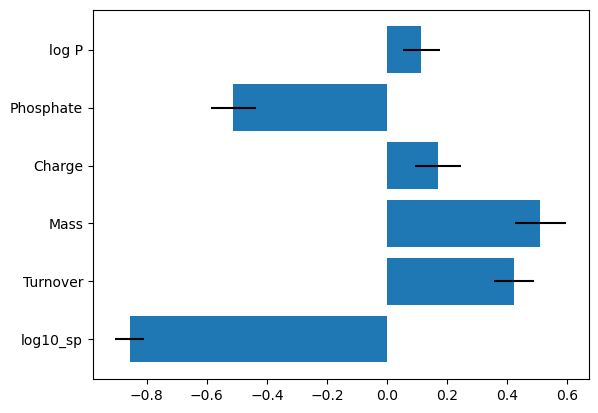

In [359]:
plt.barh(columns, coefficients.mean(axis=1), xerr = coefficients.std(axis=1))